# Parcial 1
Prgunta 5

El objetivo de este cuadernillo es el de utilizar un modelo preentrenado en este caso CONVNEXT para la clasificacion de residuos solidos

Se utilizara el dataset Taco https://github.com/pedropro/TACO

In [ ]:
import torch
import torch.nn as nn
import torchvision
import random
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
import numpy as np
import pandas as pd
import math
import zipfile
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/Taco.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Se carga el dataset

In [ ]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('Taco', transform=data_transform)
print('Imagenes:',len(dataset))
print('Numeros de clases:',len(os.listdir('Taco')))

Imagenes: 2527
Numeros de clases: 6


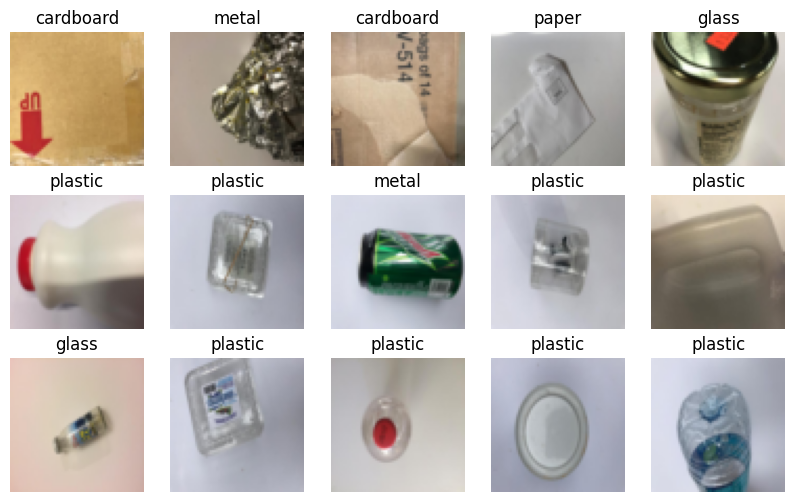

In [ ]:
classes = sorted(os.listdir('Taco'), key=lambda x: x.lower())
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset)-1)
    img, lab = dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

Se divide el dataset en conjunto de entrenamiento y prueva

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train size: 2021
test size: 506


Se crea dataloaders

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
dataloader = {
    'train': train_loader,
    'test': test_loader
}

In [ ]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape)

Forma Xi: torch.Size([32, 3, 64, 64])


Se define el modelo

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, n_outputs=5, freeze=False):
        super().__init__()
        # descargamos convnext
        convnext = torchvision.models.convnext_base(weights='DEFAULT')
        #convnext = torchvision.models.convnext_large(weights='DEFAULT')
        # nos quedamos con todas las capas menos la última
        self.convnext = torch.nn.Sequential(*list(convnext.children())[:-1])
        if freeze:
            for param in self.convnext.parameters():
                param.requires_grad = False
        # añadimos una nueva capa lineal para llevar a cabo la clasificación
        self.fc = torch.nn.Linear(1024, 6)
        #self.fc = torch.nn.Linear(1536, 6)

    def forward(self, x):
        x = self.convnext(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.convnext.parameters():
            param.requires_grad = True

Se define la funcion encarga del entrenamiento

In [ ]:
def fit(model, dataloader, epochs=5):
    #optimizer = torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=r)
    optimizer = torch.optim.Adamax([
      {'params': model.convnext.parameters(), 'lr': 1e-4},
      {'params': model.fc.parameters(), 'lr': 1e-3}
    ])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.cuda(), y.cuda()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [ ]:
model = Model(freeze=True).cuda()
fit(model, dataloader, epochs=10)
model.unfreeze()
fit(model, dataloader, epochs=10)

val_loss 0.95088 val_acc 0.67894: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 1/10 loss 1.21695 val_loss 0.95088 acc 0.56992 val_acc 0.67894


val_loss 0.81838 val_acc 0.72671: 100%|██████████| 16/16 [00:01<00:00,  9.61it/s]


Epoch 2/10 loss 0.88158 val_loss 0.81838 acc 0.70586 val_acc 0.72671


val_loss 0.75689 val_acc 0.73843: 100%|██████████| 16/16 [00:01<00:00,  9.07it/s]


Epoch 3/10 loss 0.78034 val_loss 0.75689 acc 0.74893 val_acc 0.73843


val_loss 0.71868 val_acc 0.75210: 100%|██████████| 16/16 [00:02<00:00,  7.55it/s]


Epoch 4/10 loss 0.73820 val_loss 0.71868 acc 0.76035 val_acc 0.75210


val_loss 0.69210 val_acc 0.75601: 100%|██████████| 16/16 [00:01<00:00,  9.15it/s]


Epoch 5/10 loss 0.67736 val_loss 0.69210 acc 0.78711 val_acc 0.75601


val_loss 0.67013 val_acc 0.76187: 100%|██████████| 16/16 [00:01<00:00,  9.61it/s]


Epoch 6/10 loss 0.66145 val_loss 0.67013 acc 0.78838 val_acc 0.76187


val_loss 0.65341 val_acc 0.77359: 100%|██████████| 16/16 [00:01<00:00,  9.14it/s]


Epoch 7/10 loss 0.60900 val_loss 0.65341 acc 0.80596 val_acc 0.77359


val_loss 0.64086 val_acc 0.78966: 100%|██████████| 16/16 [00:01<00:00,  8.52it/s]


Epoch 8/10 loss 0.59767 val_loss 0.64086 acc 0.81357 val_acc 0.78966


val_loss 0.62971 val_acc 0.78921: 100%|██████████| 16/16 [00:01<00:00,  9.19it/s]


Epoch 9/10 loss 0.56710 val_loss 0.62971 acc 0.81357 val_acc 0.78921


val_loss 0.62161 val_acc 0.79748: 100%|██████████| 16/16 [00:01<00:00,  9.25it/s]


Epoch 10/10 loss 0.54150 val_loss 0.62161 acc 0.82715 val_acc 0.79748


val_loss 0.48397 val_acc 0.84240: 100%|██████████| 16/16 [00:01<00:00, 10.47it/s]


Epoch 1/10 loss 0.44056 val_loss 0.48397 acc 0.84424 val_acc 0.84240


val_loss 0.44638 val_acc 0.85652: 100%|██████████| 16/16 [00:01<00:00, 10.65it/s]


Epoch 2/10 loss 0.15407 val_loss 0.44638 acc 0.94902 val_acc 0.85652


val_loss 0.42497 val_acc 0.86779: 100%|██████████| 16/16 [00:02<00:00,  7.40it/s]


Epoch 3/10 loss 0.08896 val_loss 0.42497 acc 0.96855 val_acc 0.86779


val_loss 0.47762 val_acc 0.86629: 100%|██████████| 16/16 [00:01<00:00, 10.55it/s]


Epoch 4/10 loss 0.04857 val_loss 0.47762 acc 0.98828 val_acc 0.86629


val_loss 0.45618 val_acc 0.87560: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


Epoch 5/10 loss 0.03474 val_loss 0.45618 acc 0.99268 val_acc 0.87560


val_loss 0.47362 val_acc 0.87605: 100%|██████████| 16/16 [00:01<00:00, 10.54it/s]


Epoch 6/10 loss 0.03176 val_loss 0.47362 acc 0.99268 val_acc 0.87605


val_loss 0.50439 val_acc 0.87365: 100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


Epoch 7/10 loss 0.01912 val_loss 0.50439 acc 0.99561 val_acc 0.87365


val_loss 0.49296 val_acc 0.88582: 100%|██████████| 16/16 [00:02<00:00,  7.58it/s]


Epoch 8/10 loss 0.01821 val_loss 0.49296 acc 0.99756 val_acc 0.88582


val_loss 0.49473 val_acc 0.87410: 100%|██████████| 16/16 [00:01<00:00, 10.73it/s]


Epoch 9/10 loss 0.01339 val_loss 0.49473 acc 0.99756 val_acc 0.87410


val_loss 0.49787 val_acc 0.88236: 100%|██████████| 16/16 [00:01<00:00, 10.40it/s]

Epoch 10/10 loss 0.01474 val_loss 0.49787 acc 0.99707 val_acc 0.88236


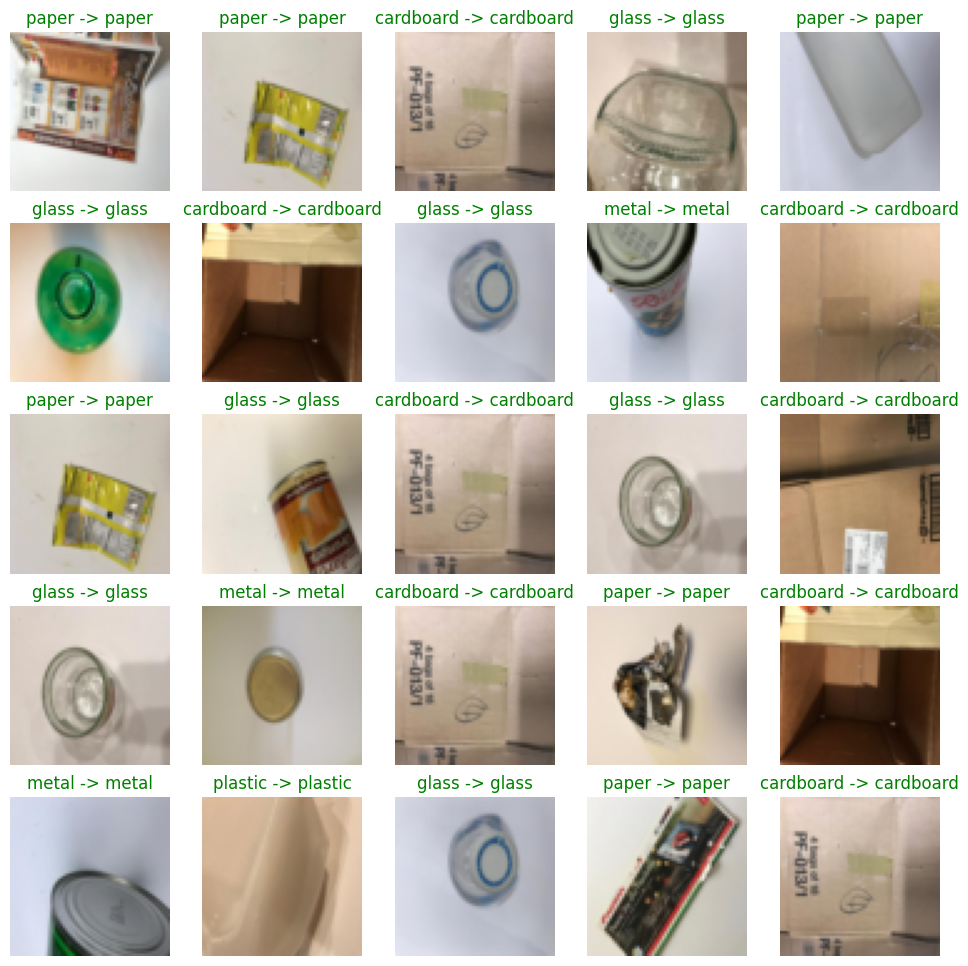

In [ ]:
model.eval()
X,y = next(iter(test_loader))
y_hat = torch.argmax(model(X.cuda()), axis=1)
fig, axs = plt.subplots(5,5, figsize=(12,12))
#index = [i for i in range(25)]
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, 31)
        img, lab = X[ix], y_hat[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0))
        # pinta de verde el titulo si la predicción es correcta, de rojo si es incorrecta
        if torch.argmax(model(img.unsqueeze(0).to(device))).item() == lab:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('green') # type: ignore
        else:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('red') # type: ignore
        ax.axis('off')
plt.show()

Los resultados obtenidos con diferentes version del modelo CONVNEXT aplicado al dataset de residuos solidos, fueron relativamente buenos, porque en varios intentos y modificaciones de los hiperparametros(lerning rate, epoch) la precision a penas llego a sobre pasar el 90% en el conjunto de prueva. Esto talvez se debe al limitado conjuno de entrenamiento, talvez utilizando Data augmentation la presicion prodria subir

In [ ]:
~